In [1]:
%load_ext autoreload

In [126]:
%autoreload
import pygmsh
from math import sin, cos, pi
import pyvista as pv
from matplotlib.pyplot import triplot
import matplotlib.pyplot as plt
from dctkit import config
from dctkit.mesh import util
import numpy as np
import meshio
from dctkit.physics.elasticity import LinearElasticity
from dctkit.math.opt import optctrl
import dctkit as dt
from jax import jit

In [127]:
config()

In [154]:
r = 1.
angle = 2*pi/4
lcar = 0.05
# lcar = 0.1

with pygmsh.geo.Geometry() as geom:
    p1 = geom.add_point([0.0, 0.0, 0.0], lcar)
    p2 = geom.add_point([-r*cos(angle/2), r*sin(angle/2), 0.0], lcar)
    p3 = geom.add_point([r, 0.0, 0.0], lcar)
    p4 = geom.add_point([-r*cos(angle/2), -r*sin(angle/2), 0.0], lcar)
    
    c0 = geom.add_circle_arc(p2, p1, p3)
    c1 = geom.add_circle_arc(p3, p1, p4)
    l1 = geom.add_line(p1, p2)
    l2 = geom.add_line(p4, p1)
    ll = geom.add_curve_loop([l1, c0, c1, l2])

    pacman = geom.add_plane_surface(ll)
    
    geom.add_physical([c0, c1], label="curved_boundary")
    # WARNING: it seems that adding physical groups made of points messes up with the other groups
    #geom.add_physical([p3], label="right_point")
    geom.add_physical([l1, l2], label="crack_faces")
    
    mesh = geom.generate_mesh()
   
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_weights()

curved_nodes = util.get_nodes_for_physical_group(mesh, 1, "curved_boundary")
crack_faces_nodes = util.get_nodes_for_physical_group(mesh, 1, "crack_faces")
crack_faces_edges = util.get_edges_for_physical_group(S, mesh, "crack_faces")
center_node = mesh.cells_dict["vertex"][0]
right_node = mesh.cells_dict["vertex"][2]

x_curved_nodes = mesh.points[curved_nodes][:,0]
y_curved_nodes = mesh.points[curved_nodes][:,1]
x_crack_nodes = mesh.points[crack_faces_nodes][:,0]
y_crack_nodes = mesh.points[crack_faces_nodes][:,1]

print("number of nodes = ", S.num_nodes)

number of nodes =  1205


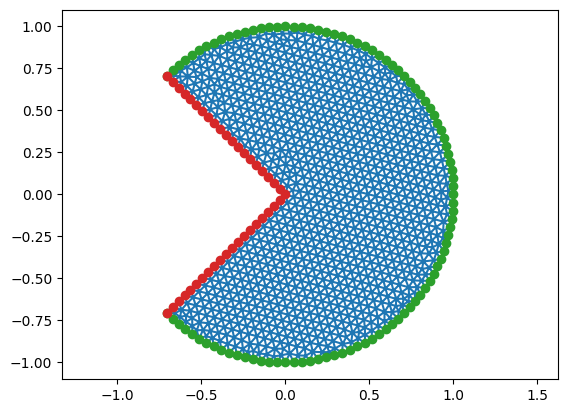

In [155]:
fig1, ax1 = plt.subplots()
ref_node_coords = S.node_coords.copy()
ax1.triplot(ref_node_coords[:,0], ref_node_coords[:,1], S.S[2])
ax1.axis('equal')
plt.plot(x_curved_nodes, y_curved_nodes, 'o')
plt.plot(x_crack_nodes, y_crack_nodes, 'o')

In [156]:
from scipy.optimize import fsolve
import jax.numpy as jnp
from jax import grad, vmap

# utility function for the calculation of the stress intensification factor vs opening angle of the V-notch
def compute_lam(omega):
    f = lambda x : jnp.sin(2*x*(pi-omega)) + x * jnp.sin(2*(pi-omega))
    return fsolve(f, 0.5)[0]

lam = compute_lam(angle/2)
print(lam)

def f(lam, omega):
    return (1+lam)*jnp.sin((1+lam)*(pi-omega))/((1-lam)*jnp.sin((1-lam)*(pi-omega)))

def F(theta, lam, omega):
    return (2*pi**(lam-1))*(jnp.cos((1+lam)*theta)-f(lam, omega)*jnp.cos((1-lam)*theta))/(1-f(lam, omega))

gradF = vmap(grad(F), in_axes=(0, None, None))
gradgradF = vmap(grad(grad(F)), in_axes=(0, None, None))
gradgradgradF = vmap(grad(grad(grad(F))), in_axes=(0, None, None))

# polar displacement components for mode I, LEFM solution
def ur(theta, r, lam, omega, E, nu):
    return (r**lam)/E*((1-nu**2)*gradgradF(theta, lam, omega) 
                       + (lam+1)*(1-nu*lam-nu**2*(lam+1))*F(theta, lam, omega))/(lam**2*(lam+1))

def utheta(theta, r, lam, omega, E, nu):
    return (r**lam)/E*((1-nu**2)*gradgradgradF(theta, lam, omega) 
                       + (2*(1+nu)*lam**2 + (lam + 1)*(1-nu*lam-nu**2*(lam+1)))*gradF(theta, lam, omega))/(lam**2*(1-lam**2))

def ux(theta, r, lam, omega, E, nu):
    return ur(theta, r, lam, omega, E, nu)*jnp.cos(theta) - utheta(theta, r, lam, omega, E, nu)*jnp.sin(theta)

def uy(theta, r, lam, omega, E, nu):
    return ur(theta, r, lam, omega, E, nu)*jnp.sin(theta) + utheta(theta, r, lam, omega, E, nu)*jnp.cos(theta)

# compute angular positions of the boundary nodes
theta = jnp.arctan2(y_curved_nodes, x_curved_nodes)

0.5444837367824638


In [157]:
E = 1.
nu = 0.3
omega = angle/2

# displacement bcs
# @jit
def update_boundary_disp(disp_mag):
    x_curved_nodes_curr = x_curved_nodes + disp_mag*ux(theta, r, lam, omega, E, nu)
    y_curved_nodes_curr = y_curved_nodes + disp_mag*uy(theta, r, lam, omega, E, nu)
    z_curved_nodes_curr = np.zeros(len(curved_nodes), dtype=dt.float_dtype)
    center_node_pos = jnp.zeros((1,3), dtype=dt.float_dtype)
    curved_nodes_pos = jnp.vstack([x_curved_nodes_curr, y_curved_nodes_curr, z_curved_nodes_curr]).T
    disp_nodes = np.array(list(center_node) + list(curved_nodes))
    disp_nodes_pos = jnp.vstack((center_node_pos, curved_nodes_pos))
    return {":": (disp_nodes, disp_nodes_pos)}

# traction bcs
bnd_tractions_free_values = np.zeros((len(crack_faces_edges), 2), dtype=dt.float_dtype)
boundary_tractions = {':': (crack_faces_edges, bnd_tractions_free_values)}

In [158]:
mu_ = E/(2*(1+nu))
lambda_ = E*nu/((1-2*nu)*(1+nu))
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 0.

In [159]:
# body force
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
body_force = np.zeros((num_faces, (embedded_dim-1))).flatten()

prb = optctrl.OptimizationProblem(dim=S.node_coords.size,
                                  state_dim=S.node_coords.size,
                                  objfun=ela.obj_linear_elasticity,
                                  solver_lib="petsc")

prb.constrained_rows = list(center_node) + list(curved_nodes) 

def objective_and_gradient(tao, x, g, **kwargs):
    """PETSc-compatible wrapper for the function that returns the objective value
    and the gradient."""
    fval, grad = prb.objandgrad(x.getArray(), **kwargs)
    resh_grad = grad.reshape(S.node_coords.shape)
    grad = resh_grad.at[prb.constrained_rows,:].set([0.,0.,0.])
    g.setArray(grad.flatten())
    return fval

prb.solver.objective_and_gradient = objective_and_gradient


In [160]:
import time
x0 = S.node_coords
tic = time.time()
for i in range(1,2):
    disp_mag = i*0.05
    print("load parameter = ", disp_mag)
    boundary_disp = update_boundary_disp(disp_mag)
    x0 = x0.reshape(S.node_coords.shape)
    x0[boundary_disp[":"][0],:]=boundary_disp[":"][1]
    x0 = x0.flatten()
    obj_args = {'f': body_force, 'gamma': gamma, 'boundary_values': boundary_disp, 
                'boundary_tractions': boundary_tractions}
    prb.set_obj_args(obj_args)
    print("running...")
    sol = prb.solve(x0=x0, gatol=1e-5, maxeval=10000, verbose=True) 
    # print("convergence result = ", prb.last_opt_result)
    x0 = sol

toc = time.time()

print("Elapsed time = ", toc - tic)
curr_node_coords = sol.reshape(S.node_coords.shape)
print(prb.last_opt_result)

load parameter =  0.05
running...
Tao Object: 1 MPI process
  type: lmvm
    Gradient steps: 1
  TaoLineSearch Object: 1 MPI process
    type: more-thuente
    maximum function evaluations=30
    tolerances: ftol=0.0001, rtol=1e-10, gtol=0.9
    total number of function evaluations=0
    total number of gradient evaluations=0
    total number of function/gradient evaluations=1
    Termination reason: 1
  convergence tolerances: gatol=1e-05,   steptol=0.,   gttol=0.
  Residual in Function/Gradient:=8.52742e-06
  Objective value=4.08438e-05
  total number of iterations=1639,                          (max: 10000)
  total number of function/gradient evaluations=1658,      (max: 4000)
  Solution converged:    ||g(X)|| <= gatol
Elapsed time =  9.987826108932495
-1


(-0.7937013970201919,
 1.1113801513199844,
 -1.207579142986874,
 1.2075791430264664)

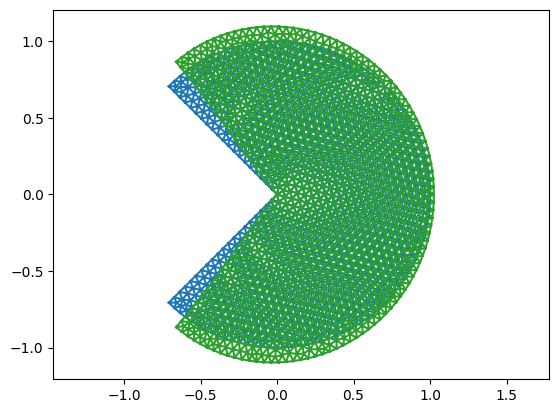

In [161]:
fig1, ax1 = plt.subplots()
ax1.triplot(ref_node_coords[:,0], ref_node_coords[:,1], S.S[2])
ax1.triplot(curr_node_coords[:,0], curr_node_coords[:,1], S.S[2])
ax1.axis('equal')

In [162]:
strains = ela.get_GreenLagrange_strain(curr_node_coords)
stresses = ela.get_stress(strains)
trace_stresses = jnp.trace(stresses, axis1=1, axis2=2)
trace_stresses = stresses[:,1,1]
print(len(trace_stresses), len(S.S[2]))

2272 2272


(-0.7924621202458749, 1.0853553390593274, -1.1, 1.1)

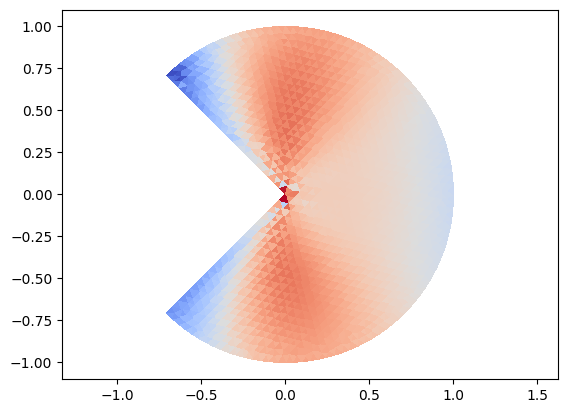

In [163]:
fig1, ax1 = plt.subplots()
ax1.tripcolor(ref_node_coords[:,0], ref_node_coords[:,1], trace_stresses, triangles=S.S[2], cmap="coolwarm")
ax1.axis('equal')